In [1]:
import sys
!pip install -q sktime
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-------------------------- Python & library version --------------------------
Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
pandas version: 1.5.3
numpy version: 1.23.5
matplotlib version: 3.7.2
tqdm version: 4.65.0
sktime version: 0.20.1
xgboost version: 1.7.6
seaborn version: 0.12.2
scikit-learn version: 1.2.2
------------------------------------------------------------------------------


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [3]:
train = pd.read_csv('/kaggle/input/big-one/train.csv').drop(['강수량(mm)', '일조(hr)', '일사(MJ/m2)'], axis=1)
# info = pd.read_csv('/kaggle/input/big-one/building_info.csv').drop(['태양광용량(kW)','ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1)
# info.columns = ['building', 'type', 'all_area', 'cool_area']
# types = info['type'].unique()
# value_dict = {value: index for index, value in enumerate(types)}
# info['type'] = info['type'].map(value_dict)

## 변수들을 영문명으로 변경
cols = ['num_date_time', 'building', 'date_time', 'temp', 'wind', 'hum', 'target']#, 'type', 'all_area', 'cool_area']
train.columns = cols
# train = pd.merge(train, info, on='building')

# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear

#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.building == x['building']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'target'].values[0], axis = 1)

power_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'day'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['day_hour_std'] = train.progress_apply(lambda x : power_mean.loc[(power_std.building == x['building']) & (power_std.hour == x['hour']) & (power_std.day == x['day']) ,'target'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.building == x['building']) & (power_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.building == x['building']) & (power_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)

### 공휴일 변수 추가
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train.loc[train['date_time'].str.match(r'^20220601 \d{2}$'), 'holiday'] = 1
train.loc[train['date_time'].str.match(r'^20220606 \d{2}$'), 'holiday'] = 1
train.loc[train['date_time'].str.match(r'^20220815 \d{2}$'), 'holiday'] = 1

power_holiday_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'holiday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['holiday_mean'] = train.progress_apply(lambda x : power_holiday_mean.loc[(power_holiday_mean.building == x['building']) & (power_holiday_mean.hour == x['hour']) & (power_holiday_mean.holiday == x['holiday']) ,'target'].values[0], axis = 1)

power_holiday_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'holiday'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['holiday_std'] = train.progress_apply(lambda x : power_holiday_std.loc[(power_holiday_std.building == x['building']) & (power_holiday_std.hour == x['hour']) & (power_holiday_std.holiday == x['holiday']) ,'target'].values[0], axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = train[train['building'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train.drop(['hour'], axis = 1, inplace = True)
train.head()

/tmp/ipykernel_32/2148817717.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['week'] = date.dt.weekofyear
100%|██████████| 204000/204000 [02:43<00:00, 1251.29it/s]


ValueError: Length of values (122400) does not match length of index (204000)

In [10]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [12]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(1,101)):
    y = train.loc[train.building == i, 'target']
    x = train.loc[train.building == i, ].iloc[:, 3:].drop(['target'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=6, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None, early_stopping_rounds=300)
    
    xgb_reg.set_params(**{'objective':weighted_mse(100)})
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], verbose=False)
    
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration+1) ## 실제 best iteration은 이 값에 +1 해주어야 함.
print(sum(scores)/len(scores))

100%|██████████| 100/100 [07:46<00:00,  4.66s/it]

2.470715819594049


In [13]:
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    y = train.loc[train.building == i+1, 'target']
    x = train.loc[train.building == i+1, ].iloc[:, 3:].drop(['target'], axis=1)
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
         gpu_id=-1, importance_type='gain', interaction_constraints='',
         learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
         min_child_weight=6, monotone_constraints='()',
         n_estimators=best_it[i], n_jobs=0, num_parallel_tree=1,
         random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=0, subsample=0.9, tree_method='exact', validate_parameters=1,
         verbosity=None,)

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)
    
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
                 gpu_id=-1, importance_type='gain', interaction_constraints='',
                 learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
                 min_child_weight=6, monotone_constraints='()',
                 n_estimators=10000, n_jobs=0, num_parallel_tree=1,
                 random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 seed=0, subsample=0.9, tree_method='exact', validate_parameters=1,
                 verbosity=None, early_stopping_rounds=300)

        xgb.set_params(**{'objective':weighted_mse(j)}) 

        xgb.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                                (x_valid, y_valid)], verbose=False)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1
    
    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print(f"building {i+1} || best score : {score0} || alpha : {best_alpha}")
    
xgb_params['alpha'] = alpha_list
xgb_params['best_it'] = best_it

xgb_params.to_csv('./hyperparameter_xgb_final.csv', index=False)

xgb_params = pd.read_csv('./hyperparameter_xgb_final.csv')
xgb_params.head()

  1%|          | 1/100 [00:23<38:27, 23.31s/it]

building 1 || best score : 3.0166099617737148 || alpha : 0


  2%|▏         | 2/100 [00:48<40:20, 24.70s/it]

building 2 || best score : 4.567518510917366 || alpha : 0


  3%|▎         | 3/100 [01:16<41:48, 25.86s/it]

building 3 || best score : 4.447388506923524 || alpha : 0


  4%|▍         | 4/100 [01:44<42:38, 26.65s/it]

building 4 || best score : 1.8532938383019928 || alpha : 0


  5%|▌         | 5/100 [02:03<37:55, 23.96s/it]

building 5 || best score : 3.6624898882686137 || alpha : 0


  6%|▌         | 6/100 [02:28<37:57, 24.23s/it]

building 6 || best score : 2.1822442381892087 || alpha : 0


  7%|▋         | 7/100 [03:15<49:19, 31.83s/it]

building 7 || best score : 3.814870519286908 || alpha : 5


  8%|▊         | 8/100 [03:40<45:20, 29.57s/it]

building 8 || best score : 2.5930112494952864 || alpha : 0


  9%|▉         | 9/100 [04:04<42:23, 27.95s/it]

building 9 || best score : 1.6248503876723002 || alpha : 0


 10%|█         | 10/100 [04:22<37:22, 24.91s/it]

building 10 || best score : 3.1665463923510315 || alpha : 0


 11%|█         | 11/100 [04:44<35:25, 23.88s/it]

building 11 || best score : 1.7699737616011229 || alpha : 0


 12%|█▏        | 12/100 [05:29<44:23, 30.27s/it]

building 12 || best score : 1.9673666971009565 || alpha : 0


 13%|█▎        | 13/100 [05:55<41:56, 28.93s/it]

building 13 || best score : 3.125811268134232 || alpha : 0


 14%|█▍        | 14/100 [06:20<40:05, 27.98s/it]

building 14 || best score : 7.988736680715588 || alpha : 0


 15%|█▌        | 15/100 [06:45<38:05, 26.89s/it]

building 15 || best score : 1.7264103543325475 || alpha : 0


 16%|█▌        | 16/100 [07:08<36:03, 25.75s/it]

building 16 || best score : 2.0609554228729556 || alpha : 0


 17%|█▋        | 17/100 [08:35<1:01:13, 44.26s/it]

building 17 || best score : 2.8693782624667428 || alpha : 0


 18%|█▊        | 18/100 [09:00<52:44, 38.59s/it]  

building 18 || best score : 3.4518819184666802 || alpha : 0


 19%|█▉        | 19/100 [09:36<50:53, 37.69s/it]

building 19 || best score : 3.9048944619481745 || alpha : 0


 20%|██        | 20/100 [10:04<46:10, 34.63s/it]

building 20 || best score : 1.9022701161753128 || alpha : 0


 21%|██        | 21/100 [10:26<40:53, 31.05s/it]

building 21 || best score : 3.5526148318855353 || alpha : 0


 22%|██▏       | 22/100 [10:53<38:39, 29.73s/it]

building 22 || best score : 1.8162417931413963 || alpha : 0


 23%|██▎       | 23/100 [11:17<36:08, 28.16s/it]

building 23 || best score : 0.7311360305118636 || alpha : 0


 24%|██▍       | 24/100 [11:34<31:12, 24.64s/it]

building 24 || best score : 1.246758191229754 || alpha : 0


 25%|██▌       | 25/100 [11:52<28:30, 22.81s/it]

building 25 || best score : 1.0779542558213961 || alpha : 0


 26%|██▌       | 26/100 [12:10<26:20, 21.35s/it]

building 26 || best score : 1.113418951902914 || alpha : 0


 27%|██▋       | 27/100 [12:28<24:31, 20.16s/it]

building 27 || best score : 0.6853282073311696 || alpha : 0


 28%|██▊       | 28/100 [12:51<25:23, 21.16s/it]

building 28 || best score : 1.9215998875988702 || alpha : 0


 29%|██▉       | 29/100 [13:14<25:47, 21.79s/it]

building 29 || best score : 1.8171842832974672 || alpha : 0


 30%|███       | 30/100 [13:54<31:29, 27.00s/it]

building 30 || best score : 3.565749766458046 || alpha : 3


 31%|███       | 31/100 [14:18<30:02, 26.12s/it]

building 31 || best score : 2.1475425750935244 || alpha : 0


 32%|███▏      | 32/100 [14:34<26:11, 23.11s/it]

building 32 || best score : 0.20974626032554178 || alpha : 0


 33%|███▎      | 33/100 [14:49<23:07, 20.70s/it]

building 33 || best score : 0.16071192929554545 || alpha : 0


 34%|███▍      | 34/100 [15:07<22:00, 20.01s/it]

building 34 || best score : 0.3694724140792104 || alpha : 0


 35%|███▌      | 35/100 [15:25<20:50, 19.24s/it]

building 35 || best score : 0.2590796276428898 || alpha : 0


 36%|███▌      | 36/100 [15:42<20:02, 18.79s/it]

building 36 || best score : 0.1882433069768075 || alpha : 0


 37%|███▋      | 37/100 [16:08<21:59, 20.94s/it]

building 37 || best score : 2.283590292307917 || alpha : 0


 38%|███▊      | 38/100 [16:39<24:35, 23.79s/it]

building 38 || best score : 2.313221080114089 || alpha : 0


 39%|███▉      | 39/100 [17:14<27:41, 27.24s/it]

building 39 || best score : 2.486612610194555 || alpha : 75


 40%|████      | 40/100 [17:43<27:35, 27.60s/it]

building 40 || best score : 5.681620853256251 || alpha : 0


 41%|████      | 41/100 [18:07<26:11, 26.64s/it]

building 41 || best score : 2.283368859050617 || alpha : 0


 42%|████▏     | 42/100 [18:50<30:36, 31.67s/it]

building 42 || best score : 5.499765688883946 || alpha : 10


 43%|████▎     | 43/100 [19:43<36:04, 37.97s/it]

building 43 || best score : 2.485033477833537 || alpha : 1


 44%|████▍     | 44/100 [20:16<34:07, 36.56s/it]

building 44 || best score : 1.6532654375293505 || alpha : 0


 45%|████▌     | 45/100 [20:35<28:42, 31.31s/it]

building 45 || best score : 1.172011543360601 || alpha : 0


 46%|████▌     | 46/100 [20:56<25:25, 28.25s/it]

building 46 || best score : 2.5464406509817388 || alpha : 0


 47%|████▋     | 47/100 [21:13<21:54, 24.80s/it]

building 47 || best score : 2.1134208921723956 || alpha : 0


 48%|████▊     | 48/100 [21:36<21:00, 24.25s/it]

building 48 || best score : 0.9292130223709795 || alpha : 0


 49%|████▉     | 49/100 [21:56<19:22, 22.79s/it]

building 49 || best score : 1.001681729529751 || alpha : 0


 50%|█████     | 50/100 [22:14<17:50, 21.42s/it]

building 50 || best score : 0.9917047585093273 || alpha : 0


 51%|█████     | 51/100 [22:35<17:25, 21.34s/it]

building 51 || best score : 1.8572466543456547 || alpha : 0


 52%|█████▏    | 52/100 [22:57<17:16, 21.59s/it]

building 52 || best score : 1.624129808238734 || alpha : 0


 53%|█████▎    | 53/100 [23:19<16:57, 21.64s/it]

building 53 || best score : 6.6947555262479295 || alpha : 0


 54%|█████▍    | 54/100 [23:56<20:15, 26.43s/it]

building 54 || best score : 14.98458836721897 || alpha : 3


 55%|█████▌    | 55/100 [24:22<19:34, 26.09s/it]

building 55 || best score : 0.7703223019087736 || alpha : 0


 56%|█████▌    | 56/100 [24:39<17:14, 23.50s/it]

building 56 || best score : 0.3214253887988418 || alpha : 0


 57%|█████▋    | 57/100 [25:09<18:11, 25.39s/it]

building 57 || best score : 2.1192952885852385 || alpha : 0


 58%|█████▊    | 58/100 [25:25<15:53, 22.70s/it]

building 58 || best score : 0.1925192473058252 || alpha : 0


 59%|█████▉    | 59/100 [26:18<21:31, 31.51s/it]

building 59 || best score : 2.1812559269353007 || alpha : 0


 60%|██████    | 60/100 [26:38<18:49, 28.24s/it]

building 60 || best score : 2.7061370019726234 || alpha : 0


 61%|██████    | 61/100 [26:58<16:37, 25.59s/it]

building 61 || best score : 1.872137719221381 || alpha : 0


 62%|██████▏   | 62/100 [27:25<16:38, 26.27s/it]

building 62 || best score : 2.178561519822039 || alpha : 0


 63%|██████▎   | 63/100 [28:17<20:56, 33.95s/it]

building 63 || best score : 2.2745182226622345 || alpha : 3


 64%|██████▍   | 64/100 [28:44<19:07, 31.88s/it]

building 64 || best score : 1.8119493958049941 || alpha : 0


 65%|██████▌   | 65/100 [29:42<23:03, 39.54s/it]

building 65 || best score : 3.953231309784184 || alpha : 0


 66%|██████▌   | 66/100 [30:45<26:28, 46.71s/it]

building 66 || best score : 1.59898698541528 || alpha : 3


 67%|██████▋   | 67/100 [31:09<21:54, 39.83s/it]

building 67 || best score : 2.3152899524806383 || alpha : 0


 68%|██████▊   | 68/100 [31:31<18:21, 34.42s/it]

building 68 || best score : 1.4802247872289942 || alpha : 0


 69%|██████▉   | 69/100 [31:49<15:19, 29.67s/it]

building 69 || best score : 1.2847809506508716 || alpha : 0


 70%|███████   | 70/100 [32:07<13:04, 26.14s/it]

building 70 || best score : 1.2049681389899158 || alpha : 0


 71%|███████   | 71/100 [32:30<12:04, 24.99s/it]

building 71 || best score : 1.9354377970542298 || alpha : 0


 72%|███████▏  | 72/100 [32:53<11:27, 24.54s/it]

building 72 || best score : 2.6859348876883042 || alpha : 0


 73%|███████▎  | 73/100 [33:10<10:02, 22.32s/it]

building 73 || best score : 1.4327467544065113 || alpha : 0


 74%|███████▍  | 74/100 [33:30<09:20, 21.55s/it]

building 74 || best score : 2.5109486843187487 || alpha : 0


 75%|███████▌  | 75/100 [33:55<09:26, 22.67s/it]

building 75 || best score : 2.4605875578704204 || alpha : 0


 76%|███████▌  | 76/100 [34:21<09:23, 23.48s/it]

building 76 || best score : 2.4938835920090354 || alpha : 0


 77%|███████▋  | 77/100 [34:46<09:15, 24.17s/it]

building 77 || best score : 1.2192778988854878 || alpha : 0


 78%|███████▊  | 78/100 [35:13<09:05, 24.81s/it]

building 78 || best score : 1.7249433846714148 || alpha : 0


 79%|███████▉  | 79/100 [35:33<08:14, 23.54s/it]

building 79 || best score : 1.6657490776721413 || alpha : 0


 80%|████████  | 80/100 [35:56<07:48, 23.41s/it]

building 80 || best score : 1.6763003964809242 || alpha : 0


 81%|████████  | 81/100 [36:34<08:45, 27.66s/it]

building 81 || best score : 1.5104333388811302 || alpha : 1


 82%|████████▏ | 82/100 [36:56<07:47, 25.96s/it]

building 82 || best score : 2.2313325873826466 || alpha : 0


 83%|████████▎ | 83/100 [37:27<07:46, 27.44s/it]

building 83 || best score : 1.536647360653014 || alpha : 0


 84%|████████▍ | 84/100 [37:54<07:16, 27.26s/it]

building 84 || best score : 1.419093877419577 || alpha : 0


 85%|████████▌ | 85/100 [38:14<06:19, 25.29s/it]

building 85 || best score : 1.564014897255343 || alpha : 0


 86%|████████▌ | 86/100 [38:48<06:28, 27.76s/it]

building 86 || best score : 2.383061954946463 || alpha : 75


 87%|████████▋ | 87/100 [39:16<06:01, 27.78s/it]

building 87 || best score : 4.799579537121962 || alpha : 0


 88%|████████▊ | 88/100 [39:49<05:54, 29.56s/it]

building 88 || best score : 4.550027126683999 || alpha : 5


 89%|████████▉ | 89/100 [40:24<05:42, 31.17s/it]

building 89 || best score : 3.347531117093381 || alpha : 100


 90%|█████████ | 90/100 [41:03<05:35, 33.51s/it]

building 90 || best score : 3.325344076150881 || alpha : 10


 91%|█████████ | 91/100 [41:53<05:44, 38.27s/it]

building 91 || best score : 5.853589387938983 || alpha : 7


 92%|█████████▏| 92/100 [42:32<05:07, 38.46s/it]

building 92 || best score : 3.4302516291228033 || alpha : 7


 93%|█████████▎| 93/100 [43:04<04:17, 36.78s/it]

building 93 || best score : 3.0921683827781203 || alpha : 0


 94%|█████████▍| 94/100 [43:28<03:16, 32.69s/it]

building 94 || best score : 3.028016753385477 || alpha : 0


 95%|█████████▌| 95/100 [43:52<02:31, 30.32s/it]

building 95 || best score : 6.7134048166130444 || alpha : 0


 96%|█████████▌| 96/100 [44:14<01:50, 27.67s/it]

building 96 || best score : 1.385166255206422 || alpha : 0


 97%|█████████▋| 97/100 [44:46<01:26, 28.99s/it]

building 97 || best score : 2.484323818616805 || alpha : 0


 98%|█████████▊| 98/100 [45:20<01:00, 30.36s/it]

building 98 || best score : 6.183428248408689 || alpha : 1


 99%|█████████▉| 99/100 [45:49<00:30, 30.22s/it]

building 99 || best score : 1.4534866502174726 || alpha : 0


100%|██████████| 100/100 [46:33<00:00, 27.94s/it]

building 100 || best score : 2.505131534054896 || alpha : 75


NameError: name 'xgb_params' is not defined

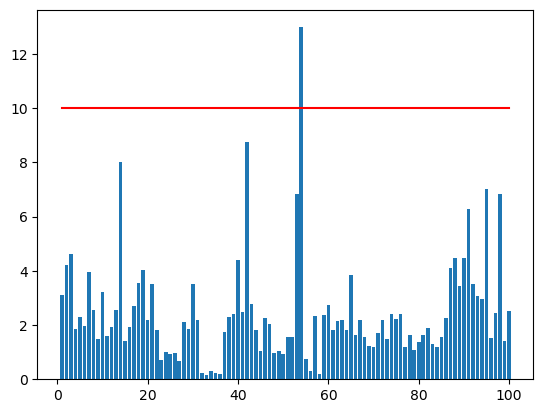

In [15]:
no_df = pd.DataFrame({'score':scores})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [10, 10], color = 'red')

In [16]:
# train set과 동일한 전처리 과정
test = pd.read_csv('/kaggle/input/big-one/test.csv').drop(['강수량(mm)'], axis=1)
cols = ['num_date_time', 'building', 'date_time', 'temp', 'wind','hum']
test.columns = cols
# test = pd.merge(test, info, on='building')
date = pd.to_datetime(test.date_time)
test['hour'] = date.dt.hour
test['day'] = date.dt.weekday
test['month'] = date.dt.month
test['week'] = date.dt.weekofyear
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)
test['holiday'] = test.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## 건물별 일별 시간별 발전량 평균
#power_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
test['day_hour_mean'] = test.progress_apply(lambda x : power_mean.loc[(power_mean.building == x['building']) & (power_mean.day == x['day']) & (power_mean.hour == x['hour']) ,'target'].values[0], axis = 1)

#power_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'day'], aggfunc = np.std).reset_index()
tqdm.pandas()
test['day_hour_std'] = test.progress_apply(lambda x : power_mean.loc[(power_std.building == x['building']) & (power_std.hour == x['hour']) & (power_std.day == x['day']) ,'target'].values[0], axis = 1)

## 건물별 시간별 발전량 평균 넣어주기
#power_hour_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
test['hour_mean'] = test.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.building == x['building']) & (power_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)

#power_hour_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
test['hour_std'] = test.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.building == x['building']) & (power_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)

#power_holiday_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'holiday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
test['holiday_mean'] = test.progress_apply(lambda x : power_holiday_mean.loc[(power_holiday_mean.building == x['building']) & (power_holiday_mean.hour == x['hour']) & (power_holiday_mean.holiday == x['holiday']) ,'target'].values[0], axis = 1)

#power_holiday_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'holiday'], aggfunc = np.std).reset_index()
tqdm.pandas()
test['holiday_std'] = test.progress_apply(lambda x : power_holiday_std.loc[(power_holiday_std.building == x['building']) & (power_holiday_std.hour == x['hour']) & (power_holiday_std.holiday == x['holiday']) ,'target'].values[0], axis = 1)

test.drop(['hour'], axis = 1, inplace = True)

test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = test[test['building'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

new_order = ['num_date_time', 'building', 'date_time', 'temp', 'wind', 'hum', 'day', 'month', 'week', 'day_hour_mean', 'day_hour_std', 'hour_mean', 'hour_std', 'holiday', 'holiday_mean', 'holiday_std', 'sin_time', 'cos_time', 'THI', 'CDH']
test = test.reindex(columns=new_order)
test.head()

/tmp/ipykernel_32/3580254078.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['week'] = date.dt.weekofyear
100%|██████████| 16800/16800 [00:14<00:00, 1180.84it/s]


,num_date_time,building,date_time,temp,wind,hum,day,month,week,day_hour_mean,day_hour_std,hour_mean,hour_std,holiday,holiday_mean,holiday_std,sin_time,cos_time
0,1_20220825 00,1,20220825 00,23.5,2.2,72,3,8,34,1627.80,1627.80,1706.318118,446.882767,0,1745.880000,454.860172,0.000000,1.000000
1,1_20220825 01,1,20220825 01,23.0,0.9,72,3,8,34,1550.08,1550.08,1622.620235,439.662704,0,1660.626207,449.601717,0.258819,0.965926
2,1_20220825 02,1,20220825 02,22.7,1.5,75,3,8,34,1431.12,1431.12,1506.971294,412.071906,0,1546.183448,417.125197,0.500000,0.866025
3,1_20220825 03,1,20220825 03,22.1,1.3,78,3,8,34,1372.20,1372.20,1437.365647,391.205981,0,1487.929655,387.734123,0.707107,0.707107
4,1_20220825 04,1,20220825 04,21.8,1.0,77,3,8,34,1381.72,1381.72,1447.321412,381.099697,0,1498.324138,373.004526,0.866025,0.500000


In [25]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4]: # 각 시드별 예측
        y_train = train.loc[train.building == i+1, 'target']
        x_train, x_test = train.loc[train.building == i+1, ].iloc[:, 3:].drop(['target'], axis=1), test.loc[test.building == i+1, ].iloc[:,3:]
        x_test = x_test[x_train.columns]
        
        
        xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
                 gpu_id=-1, importance_type='gain', interaction_constraints='',
                 learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
                 min_child_weight=6, monotone_constraints='()',
                 n_estimators=best_it[i], n_jobs=0, num_parallel_tree=1,
                 random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 seed=seed, subsample=0.9, tree_method='exact', validate_parameters=1,
                 verbosity=None)
        
        if xgb_params.loc[i, 'alpha'] != 0:
            xgb.set_params(**{'objective':weighted_mse(xgb_params.loc[i, 'alpha'])})
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   
    
submission = pd.read_csv('/kaggle/input/big-one/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('./submission_xgb.csv', index = False)

100%|██████████| 100/100 [11:56<00:00,  7.16s/it]
